# Comparative analysis of sector coupled model with and without inclusion of H2-SF - EAF-based iron and steel plants

This notebook builds two models using the EU-SES modelling tool and the calliope model framework. Both model uses Germany as a case study.
The first model contains Iron and Steel plants that operate using H2-SF and EAF to produce steel. 
The second model omits the Iron and Steel plants.


## Import packages

In [1]:
import calliope
import numpy as np
import os, sys
os.chdir(os.getcwd().replace('examples',''))
import euses
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mapclassify
import geopandas as gpd

## Import existing areas dataset and add Iron and Steel Industry

The locations and annual production capacity of the iron and steel plants are taken from hotmaps industrial database [hotmaps industrial database](https://gitlab.com/hotmaps/industrial_sites/industrial_sites_Industrial_Database) ad added to euses areas dataset.
The production values for Germany are significantly different from documented values. Therefore the production capacity values are manually corrected.
The hourly hydrogen and power demand are added to the euses areas dataset. 
hourly hydrogen demand (kg) = h2_per_t * hourly steel production 
hourly steel production = annual production capacity / 8760

The hourly hydrogen demand in the euses areas dataset is represented in energy unit MWh. 
hourly hydrogen demand (MWh) =  hourly hydrogen demand (kg) * h2_kWh_per_kg / 1e3

hourly power demand = hourly EAF power demand + hourly addition power demand
hourly power demand = (power_eaf+power_add) * hourly steel production


In [2]:
eu_ds = euses.import_dataset('euses_datasets.nc')
eu_ds.add('Iron_and_Steel', h2_per_t = 60, h2_kWh_per_kg = 33.33, power_eaf = 0.65,
          power_add = 0.32, dic_correction = {'DE':45e6})
ds = eu_ds.ds

/home/dozeumflc/anaconda3/envs/euses/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



## Show spatial disribution of Iron and Steel plan production capacity in Germany. 

<AxesSubplot:>

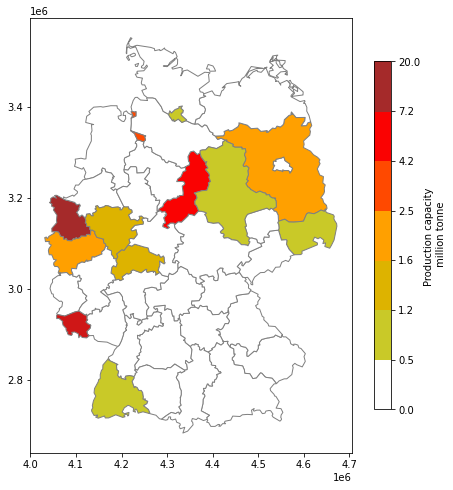

In [12]:
eu_ds_ge = eu_ds.filter_countries(['Germany'])


isr = gpd.GeoDataFrame(data=eu_ds_ge.ds['industries'].loc[{'sector':'Iron and steel'}]/1e6,geometry=eu_ds_ge.ds['geometry'].values,columns=['capacity'])
isr = isr.fillna(0)

fig, ax = plt.subplots(figsize=(8,8))
fj = mapclassify.FisherJenks(isr["capacity"], k=8)
bounds = fj.bins.tolist()
bounds = bounds[1:]
bounds.insert(0,0)
bounds1=[]
for v in bounds:
    if v>10:
        bounds1.append(round(v, -1))
    else:
        bounds1.append(round(v, 1))
bounds = bounds1

norm = colors.BoundaryNorm(bounds, len(bounds))
cmap = colors.LinearSegmentedColormap.from_list('name',colors=['w','y','orange','r','brown'], N=len(bounds), gamma=.8)
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
ax_cbar = fig.colorbar(cbar, ax=ax, orientation = 'vertical',shrink=0.8, label='Production capacity \n million tonne')
isr.plot(ax=ax,column='capacity',cmap=cmap,edgecolor='grey',scheme='Fisher_Jenks',k=8)

## Euses areas dataset is ammended to create scenario 
Only existing power plants technologies considered are Biomass and biogas, Natural gas, Solar, Wind and Wind Offshore. Biomass and biogas and Natural gas plants are grouped together as Combined cycle plants.

In [6]:
# remove power plants not considered
fuels_considered = ['Biomass and biogas','Natural gas','Solar','Wind']
fuels_removed = np.setdiff1d(eu_ds.ds.coords['fuel'].values,fuels_considered)
eu_ds.ds = eu_ds.ds.drop(fuels_removed,dim='fuel')
tech_not_grouped = ['Solar','Wind','Wind Offshore']
tech_list = np.setdiff1d(eu_ds.ds.coords['tech'].values,tech_not_grouped)
# group natural gas and biomass/biogas based power_plants in single group
sum_var = eu_ds.ds['power_plants'].loc[:,tech_list,:].sum(axis=1)
tech_list = np.setdiff1d(tech_list,['Combined cycle'])
eu_ds.ds['power_plants'].loc[:,['Combined cycle']] = [[g] for g in sum_var.values]
eu_ds.ds = eu_ds.ds.drop(tech_list,dim='tech')
# only percentage of rooftop_pv and utility_pv area considered
eu_ds.ds['rooftop_pv'] = eu_ds.ds['rooftop_pv']*1
eu_ds.ds['utility_pv'] = eu_ds.ds['utility_pv']*0.50

/home/dozeumflc/anaconda3/envs/euses/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).

/home/dozeumflc/anaconda3/envs/euses/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning:

dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).



## Create first model considering hydrogen and power demand from Iron and Steel plant

In [7]:
filt_ds = eu_ds.filter_countries(['Germany'])
filt_ds.create_regions('poli_regions')
filt_ds.create_calliope_model(op_mode='plan',sectors=['power','heat','iron and steel'],co2_cap_factor=0.2, national=True)

model = calliope.Model('calliope_model/model.yaml',scenario='time_3H',override_dict={'run.solver': 'cbc'})
model.run()

/home/dozeumflc/anaconda3/envs/euses/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/home/dozeumflc/anaconda3/envs/euses/lib/python3.7/site-packages/calliope/exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Model configuration specifies calliope_version=0.6.5, but you are running 0.6.6-post1. Proceed with caution!

/home/dozeumflc/anaconda3/envs/euses/lib/python3.7/site-packages/calliope/exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * All technologies were requested for inclusion in group constraint `systemwide_co2_cap`, but those from tech group(s) `[]` have been ignored as one or more of the constraints cannot be applied to technologies in these group

## Create second model not considering hydrogen and power demand from Iron and Steel plant

In [8]:
filt_ds_v2 = eu_ds.filter_countries(['Germany'])
filt_ds_v2.ds['industries_demand'] = filt_ds_v2.ds['industries_demand'] * 0
filt_ds_v2.create_regions('poli_regions')
filt_ds_v2.create_calliope_model(op_mode='plan',sectors=['power','heat','iron and steel'],co2_cap_factor=0.2, national=True)
model_v2 = calliope.Model('calliope_model/model.yaml',scenario='time_3H',override_dict={'run.solver': 'cbc'})
model_v2.run()

/home/dozeumflc/anaconda3/envs/euses/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/home/dozeumflc/anaconda3/envs/euses/lib/python3.7/site-packages/calliope/exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Model configuration specifies calliope_version=0.6.5, but you are running 0.6.6-post1. Proceed with caution!

/home/dozeumflc/anaconda3/envs/euses/lib/python3.7/site-packages/calliope/exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * All technologies were requested for inclusion in group constraint `systemwide_co2_cap`, but those from tech group(s) `[]` have been ignored as one or more of the constraints cannot be applied to technologies in these group

## Plot some comparative results

The first plot is the installed capacity percentage change of the listed technologies of model one with model two. 

<AxesSubplot:xlabel='locs'>

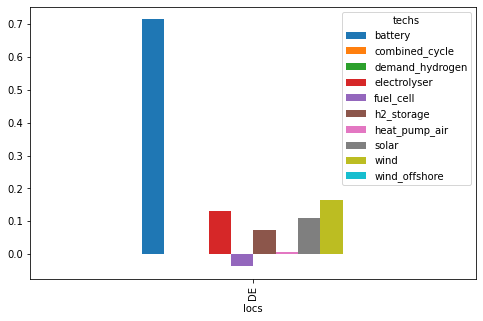

In [9]:
techs_selecion = ['battery', 'combined_cycle', 'demand_hydrogen',
                    'electrolyser', 'fuel_cell', 'h2_storage',
                    'heat_pump_air', 'solar', 'wind', 'wind_offshore']

((model.get_formatted_array('energy_cap').loc[{'techs':techs_selecion}]-model_v2.get_formatted_array('energy_cap').loc[{'techs':techs_selecion}])/model_v2.get_formatted_array('energy_cap').loc[{'techs':techs_selecion}]).to_pandas().plot.bar(figsize=(8,5))

The second plot compares the levelised cost percentage change of gas, hydrogen and heat production of model one with model two.
The inclusion of iron and steel power and hydrogen demand reduces the hydrogen and electricity but increases the levelised cost of heat and gas production.

<AxesSubplot:xlabel='carriers'>

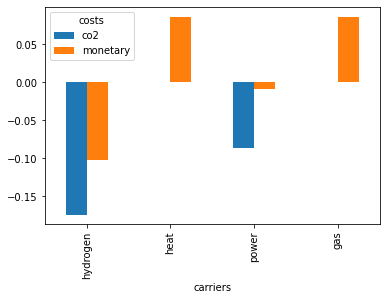

In [10]:
((model.results['total_levelised_cost']-model_v2.results['total_levelised_cost'])/model_v2.results['total_levelised_cost']).to_pandas().plot.bar()